In [5]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import time

from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


In [6]:

    
# FUNCTIONS NEEDED FOR ALL MODELS  ============================================

# function slightly modified from https://nlpforhackers.io/topic-modeling/

def print_topics(model, vectorizer, top_n=10):
    for idx, topic in enumerate(model.components_):  # loop through each row of H.  idx = row index.  topic = actual row
        print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        print_list = [(vectorizer.get_feature_names()[i], topic[i])  
                        for i in topic.argsort()[:-top_n - 1:-1]]
        for item in print_list:
            print(item)
            


In [26]:
# DATA INGESTION =========================================================



# import entire dataset

f = pd.read_csv('../../data/original/working_federal_reporter_2020.csv',engine='python')

df = f[pd.notnull(f["ABSTRACT"])]#TextCleaning.remove_nulls(raw_df, "ABSTRACT")
df = df.drop_duplicates()#TextCleaning.remove_duplicates(df)
#Random 20% of dataset:
df_samp = df.sample(frac = .2).reset_index()

docs = df_samp["ABSTRACT"]



In [27]:
# CREATE DOC-TERM MATRIX  ============================================================================

vectorizer = CountVectorizer()#CountVectorizer(max_df=0.4, min_df=3, lowercase=False, max_features=int(len(docs)/2))
doc_term_matrix = vectorizer.fit_transform(docs)


In [28]:
# input needed for LDA, NMF and LSA (all from Scikit-Learn) is one string per document (not a list of strings)

#text = []
#for doc in docs:
#    text.append(" ".join(doc))

In [29]:
# LDA RUNS ===================================================================================

# function adapted from https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/
i = 9000
num_topics = 10

# create model
t1 = time.time()
lda_model = LatentDirichletAllocation(n_components=num_topics, doc_topic_prior = 1/num_topics, 
                                      topic_word_prior=0.1, n_jobs=39, random_state = i)
lda_model.fit_transform(doc_term_matrix)
t2 = time.time()
print(f"  Model time: {t2-t1}")

# print out topics
print_topics(lda_model, vectorizer, top_n=10)

        


  Model time: 299.5576345920563

Topic 0:
('of', 294636.280967733)
('the', 293135.719080621)
('and', 281139.3075953906)
('in', 260472.2971421689)
('to', 159692.40254847356)
('that', 95577.82589643379)
('is', 86064.03437927984)
('will', 64726.52062018112)
('by', 64604.515892633935)
('we', 57957.26867644454)

Topic 1:
('myc', 3489.985202221497)
('sm', 1061.1646990157242)
('erbb', 667.1065260242234)
('sclc', 400.88591273646733)
('abstract', 388.8067491801641)
('provided', 376.2575358776747)
('erbb2', 332.0919833329573)
('tbk1', 321.08828528036315)
('not', 273.42758274412853)
('erbb3', 270.4950803213915)

Topic 2:
('the', 293897.97799896164)
('of', 292276.506234513)
('and', 259861.11742983825)
('in', 237825.5853462397)
('to', 173632.96518032122)
('that', 92912.26420789042)
('will', 84069.26071484397)
('is', 73359.28079072856)
('we', 73288.63170398511)
('with', 64048.56636202723)

Topic 3:
('of', 345620.2911704805)
('the', 343611.48168955755)
('and', 283534.0519004777)
('to', 247846.4656336

In [30]:
#Create transformed Doc-Term Matrix to allow Document-Topic distribution analysis

doc_topic = lda_model.transform(doc_term_matrix)

In [17]:
#Lists most likely topic for each document (optional)

#for n in range(doc_topic.shape[0]):
#    topic_most_pr = doc_topic[n].argmax()
#    top = doc_topic[n]
#    print("doc: {} topic: {} chunk: {}\n".format(n,topic_most_pr, top[topic_most_pr]))

doc: 0 topic: 5 chunk: 0.9967970413881165

doc: 1 topic: 1 chunk: 0.9968748817723194

doc: 2 topic: 2 chunk: 0.99464262663689

doc: 3 topic: 5 chunk: 0.992436529799913

doc: 4 topic: 2 chunk: 0.9950817683272862

doc: 5 topic: 4 chunk: 0.9970872648083814



In [38]:
#Pulls sample data subsetted by year then takes mean theta for each abstract

topic_frame = pd.DataFrame(doc_topic)
#topic_frame["ABSTRACT"] = df_samp["ABSTRACT"]
topic_frame["FY"] = df_samp["FY.x"]
topic_frame["FY"] = topic_frame["FY"].apply(lambda x : np.int64(x))
topic_frame = topic_frame.groupby("FY").mean().reset_index()
topic_frame.sort_values(by = "FY")

,FY,0,1,2,3,4,5,6,7,8,9
0,2008,0.081779,0.005176,0.071670,0.093485,0.130190,0.143703,0.177581,0.070454,0.079542,0.146420
1,2009,0.082114,0.002676,0.075944,0.092888,0.138048,0.145183,0.178175,0.069669,0.079176,0.136128
2,2010,0.081130,0.001893,0.074607,0.094745,0.141847,0.146950,0.173075,0.068942,0.083754,0.133057
3,2011,0.079790,0.001151,0.075972,0.094746,0.150803,0.139215,0.168539,0.068364,0.087800,0.133620
4,2012,0.079440,0.001267,0.079119,0.100208,0.153926,0.143049,0.164015,0.069073,0.094324,0.115580
5,2013,0.080864,0.001261,0.078120,0.101882,0.151362,0.144231,0.161041,0.068867,0.098952,0.113420
6,2014,0.077757,0.001712,0.081046,0.099855,0.152344,0.145670,0.159410,0.066747,0.099667,0.115792
7,2015,0.075454,0.001368,0.082672,0.101962,0.152916,0.153926,0.153244,0.066193,0.103008,0.109257
8,2016,0.076854,0.001550,0.082568,0.102623,0.158073,0.143271,0.153151,0.064283,0.106485,0.111143
9,2017,0.073427,0.001356,0.088492,0.106071,0.156129,0.132810,0.150918,0.067207,0.111446,0.112145


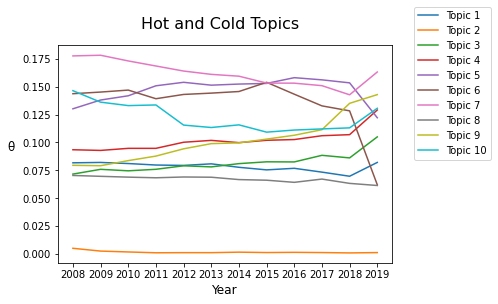

In [66]:
#Make Graphs
leg = []
fig = plt.figure()
fig.suptitle('Hot and Cold Topics', fontsize=16)
ax = fig.add_subplot(111)
for n in range(num_topics):
    ax.plot(topic_frame["FY"],topic_frame[n])
    leg.append("Topic %d"%(n+1))

plt.xticks(np.arange(topic_frame["FY"].min(), topic_frame["FY"].max()+1, 1.0))
plt.xlabel('Year', fontsize=12)
plt.ylabel('θ', fontsize=12, rotation = 0)
ax.yaxis.set_label_coords(-0.14,0.5)
plt.legend(leg,bbox_to_anchor=(1.05, 1.0, 0.3, 0.2), loc='upper left')
plt.show()

In [24]:
df["FY.x"].loc[:5]

0    2008.0
1    2008.0
2    2008.0
3    2008.0
4    2008.0
5    2008.0
Name: FY.x, dtype: float64